# DAY-AHEAD BASELINE MODEL

## 2025 ENTSO-E data BZN|NL

Residual load x price correlation: day-ahead prices bheaviour as a function of residual load

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

repo_root = Path("..").resolve()
sys.path.append(str(repo_root))


#Load 2025 ENTSO-E data
from Source.load_data import load_2025

df_market = load_2025()
df_market = df_market.T.drop_duplicates().T

mtu = df_market['MTU (CET/CEST)'].iloc[:,0]
df_market['Time'] = mtu.str.split(' - ').str[0]
df_market['Time'] = df_market['Time'].str.replace(r"\s*\(.*\)", "", regex=True).str.strip()
df_market['Time'] = pd.to_datetime(df_market['Time'], dayfirst=True)

df_market['Hour'] = df_market['Time'].dt.hour
df_market['Day'] = df_market['Time'].dt.day
df_market['Month'] = df_market['Time'].dt.month


df_market.tail()

,MTU (CET/CEST),Area,Sequence,Day-ahead Price (EUR/MWh),Total Generation Forecast (MW),Total Actual Generation (MW),MTU (CET/CEST),Actual Total Load (MW),Day-ahead Total Load Forecast (MW),Day-ahead offshore wind (MW),Actual offshore wind (MW),Day-ahead onshore wind (MW),Actual onshore wind (MW),Day-ahead solar (MW),Actual solar (MW),Time,Hour,Day,Month
35035,31/12/2025 22:45:00 - 31/12/2025 23:00:00,BZN|NL,Without Sequence,73.76,10688.22,8141.58,31/12/2025 22:45 - 31/12/2025 23:00,10602.18,11600.78,1057,4027.5,2109,808.08,0,0.0,2025-12-31 22:45:00,22,31,12
35036,31/12/2025 23:00:00 - 31/12/2025 23:15:00,BZN|NL,Without Sequence,87.16,10029.89,8164.07,31/12/2025 23:00 - 31/12/2025 23:15,10617.95,11397.23,1088,4076.18,2155,810.64,0,0.0,2025-12-31 23:00:00,23,31,12
35037,31/12/2025 23:15:00 - 31/12/2025 23:30:00,BZN|NL,Without Sequence,74.27,9800.48,8158.97,31/12/2025 23:15 - 31/12/2025 23:30,10665.56,11343.97,1116,4116.6,2204,794.55,0,0.0,2025-12-31 23:15:00,23,31,12
35038,31/12/2025 23:30:00 - 31/12/2025 23:45:00,BZN|NL,Without Sequence,67.6,9716.1,8056.36,31/12/2025 23:30 - 31/12/2025 23:45,10590.58,11094.52,1140,4069.39,2254,790.05,0,0.0,2025-12-31 23:30:00,23,31,12
35039,31/12/2025 23:45:00 - 01/01/2026 00:00:00,BZN|NL,Without Sequence,67.6,9539.61,8044.8,31/12/2025 23:45 - 01/01/2026 00:00,10433.0,10680.22,1164,4209.28,2303,856.55,0,0.0,2025-12-31 23:45:00,23,31,12


Pearsons correlation> actual: 0.511
Pearsons correlation> day-ahead: 0.760


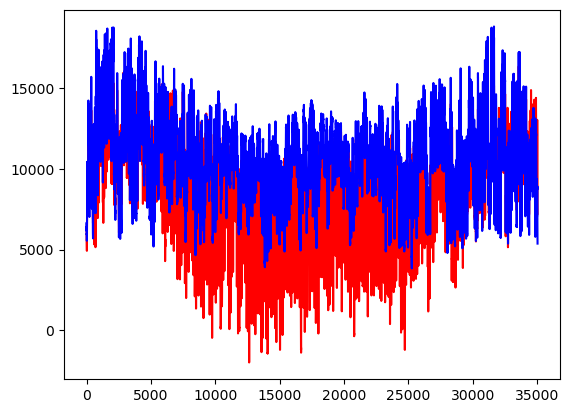

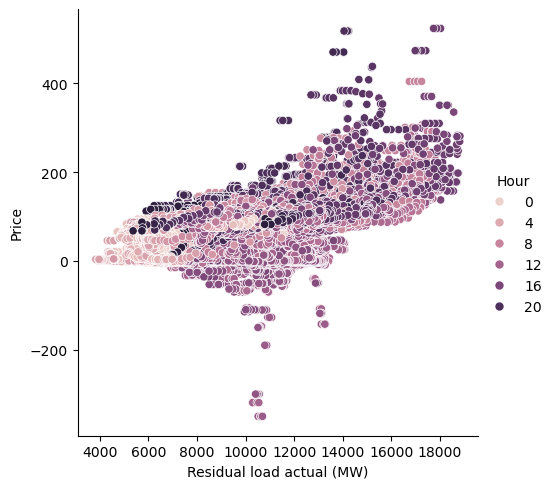

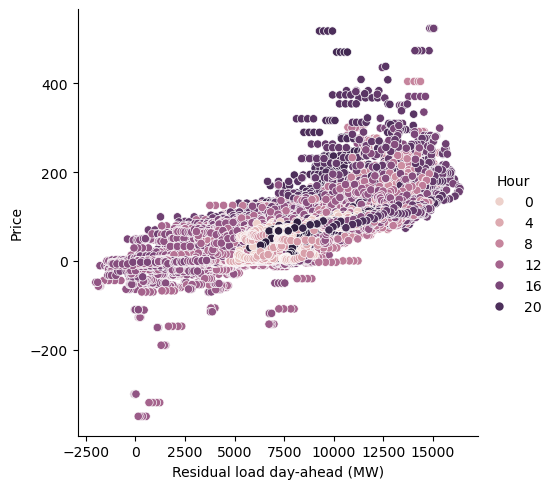

In [2]:
#Indexing
x = df_market.index

#Residual load: Total Load - Generation from Renewables

residual_load_da = df_market['Day-ahead Total Load Forecast (MW)'] - df_market['Day-ahead offshore wind (MW)'] - df_market['Day-ahead onshore wind (MW)'] - df_market['Day-ahead solar (MW)']
residual_load_actual = df_market['Actual Total Load (MW)'] - df_market['Actual offshore wind (MW)'] - df_market['Actual onshore wind (MW)'] - df_market['Actual solar (MW)']


plt.plot(x,residual_load_da,'r', residual_load_actual, 'b')

price_load = pd.DataFrame({'Residual load actual (MW)':residual_load_actual,'Residual load day-ahead (MW)':residual_load_da,'Price': df_market['Day-ahead Price (EUR/MWh)']})
price_load['Month'] = df_market['Month']
price_load['Hour'] = df_market['Hour']

sns.relplot(x ="Residual load actual (MW)", y ="Price", hue = 'Hour',
            data = price_load)
corr_actual, _ = pearsonr(residual_load_actual.to_numpy(dtype=float), df_market['Day-ahead Price (EUR/MWh)'].to_numpy(dtype=float))
print('Pearsons correlation> actual: %.3f' % corr_actual)

sns.relplot(x ="Residual load day-ahead (MW)", y ="Price", hue = 'Hour',
            data = price_load)
corr_da, _ = pearsonr(residual_load_da.to_numpy(dtype=float), df_market['Day-ahead Price (EUR/MWh)'].to_numpy(dtype=float))
print('Pearsons correlation> day-ahead: %.3f' % corr_da)

In [15]:
print(price_load.head())

dtypes = price_load[[
    "Price",
    "Residual load day-ahead (MW)"
]].dtypes

dtypes

price_load["Price"] = pd.to_numeric(price_load["Price"], errors="coerce")
price_load["Residual load day-ahead (MW)"] = pd.to_numeric(
    price_load["Residual load day-ahead (MW)"],
    errors="coerce"
)

dtypes = price_load[[
    "Price",
    "Residual load day-ahead (MW)"
]].dtypes

dtypes

  Residual load actual (MW)  Residual load day-ahead (MW)  Price  Month  Hour
0                   6217.86                       6199.38  13.62      1     0
1                   6143.04                       6151.90  13.62      1     0
2                   6408.02                       6004.90  13.62      1     0
3                   6269.17                       5863.26  13.62      1     0
4                   6676.54                       5754.04   6.24      1     1


Price                           float64
Residual load day-ahead (MW)    float64
dtype: object

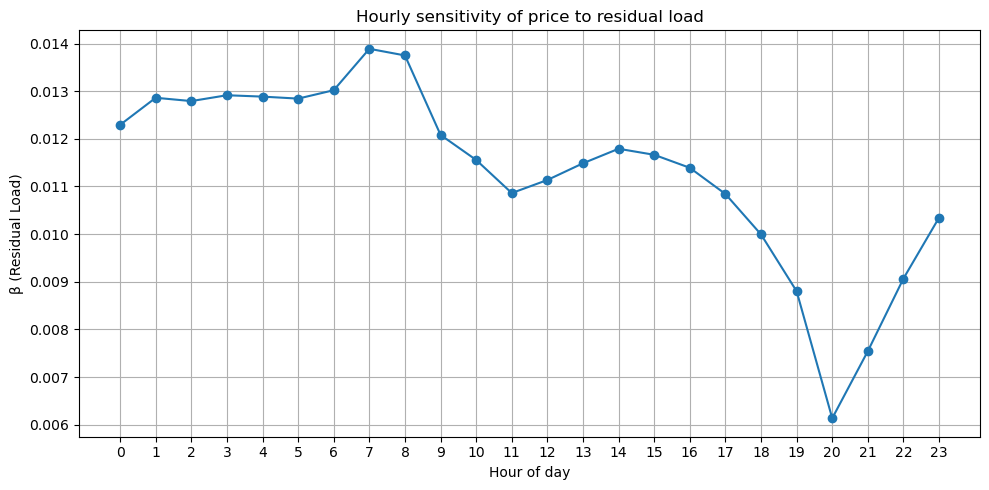

In [22]:
import statsmodels.api as sm

hourly_mean_price = (
    price_load
    .groupby("Hour")["Price"]
    .mean()
)

models_rl = {}
coefficients = []

for hour in range(24):
    d = price_load[price_load["Hour"] == hour]
    
    X = sm.add_constant(d["Residual load day-ahead (MW)"])
    y = d["Price"]
    
    model = sm.OLS(y, X).fit()
    models_rl[hour] = model
    
    coefficients.append({
        "Hour": hour,
        "alpha": model.params["const"],
        "beta_residual_load": model.params["Residual load day-ahead (MW)"],
        "r2": model.rsquared
    })

coef_df = pd.DataFrame(coefficients)
coef_df_sorted = coef_df.sort_values("Hour")

plt.figure(figsize=(10, 5))
plt.plot(
    coef_df_sorted["Hour"],
    coef_df_sorted["beta_residual_load"],
    marker="o"
)

plt.xlabel("Hour of day")
plt.ylabel("β (Residual Load)")
plt.title("Hourly sensitivity of price to residual load")

plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()